In [2]:
import pandas as pd

In [3]:
dfdev = pd.read_csv('./data/dev.csv')[['text','intent']]
dftrain = pd.read_csv('./data/train.csv')[['text','intent']]
dftest = pd.read_csv('./data/test.csv')[['text','intent']]
dftest = pd.concat([dfdev,dftest])

In [4]:
dftrain.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [5]:
dftrain['intent'].value_counts()

intent
PlayMusic               1914
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
Name: count, dtype: int64

In [6]:
dftest['intent'].value_counts()

intent
AddToPlaylist           224
SearchCreativeWork      207
SearchScreeningEvent    207
GetWeather              204
BookRestaurant          192
PlayMusic               186
RateBook                180
Name: count, dtype: int64

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

N_CLIENTS = 10
DIRICHLET_ALPHA = 1.0

# Encode labels
le = LabelEncoder()
dftrain['intent_label'] = le.fit_transform(dftrain['intent'])

def split_noniid_text(dftrain, alpha, n_clients):
    train_labels = dftrain['intent_label'].values
    train_idcs = np.arange(len(train_labels))
    n_classes = train_labels.max() + 1

    label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
    class_idcs = [np.argwhere(train_labels == y).flatten() for y in range(n_classes)]

    client_idcs = [[] for _ in range(n_clients)]
    for c, fracs in zip(class_idcs, label_distribution):
        splits = np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))
        for i, idcs in enumerate(splits):
            client_idcs[i].extend(idcs.tolist())

    return client_idcs

# Apply non-IID splitting
client_idcs = split_noniid_text(dftrain, DIRICHLET_ALPHA, N_CLIENTS)
client_data = [dftrain.iloc[idcs].reset_index(drop=True) for idcs in client_idcs]




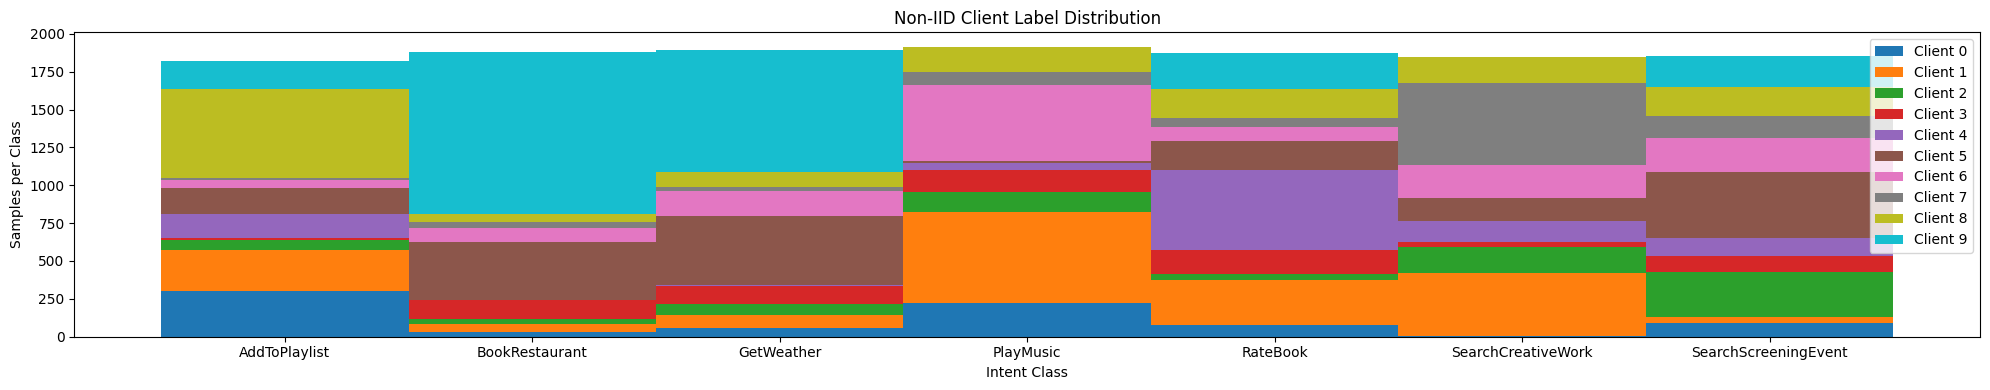

In [8]:
# visualize label distribution
plt.figure(figsize=(20, 4))
plt.hist([dftrain['intent_label'].iloc[idcs] for idcs in client_idcs],
         stacked=True, bins=np.arange(len(le.classes_)+1)-0.5,
         label=[f"Client {i}" for i in range(N_CLIENTS)])
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=0)
plt.xlabel("Intent Class")
plt.ylabel("Samples per Class")
plt.title("Non-IID Client Label Distribution")
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\Pankhuri\anaconda3\envs\chatbotfl\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


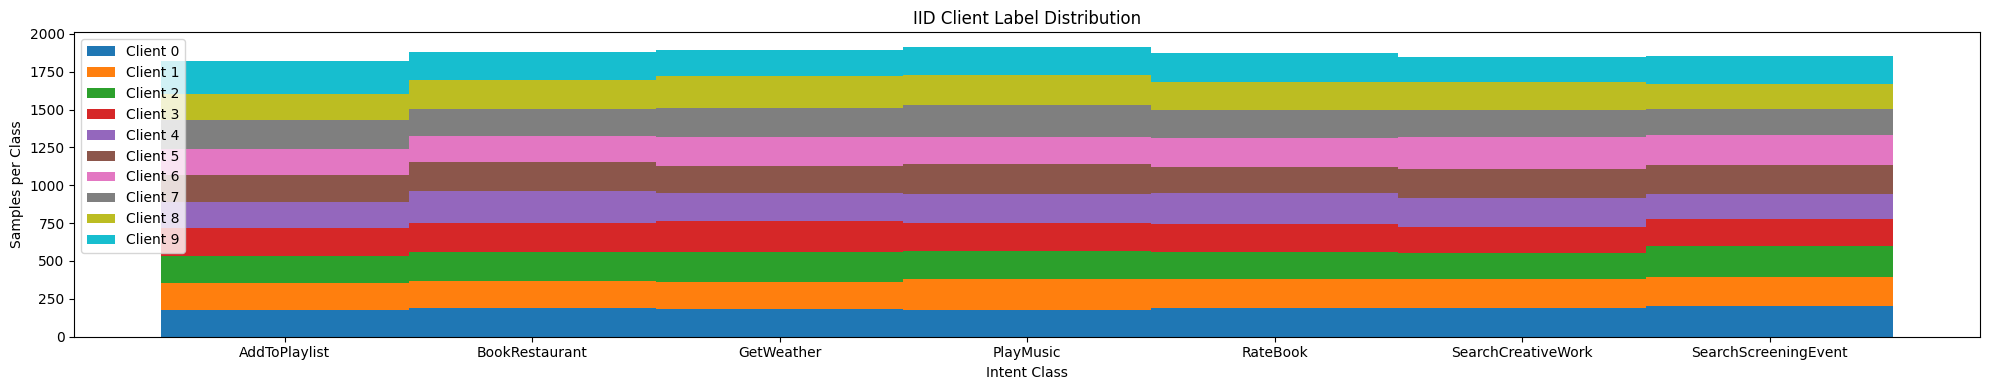

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming train_df is already loaded and has 'utterance' and 'intent' columns
N_CLIENTS = 10

# Encode intent labels
le = LabelEncoder()
dftrain['intent_label'] = le.fit_transform(dftrain['intent'])

# Shuffle the data
shuffled_df = dftrain.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split data into IID partitions
client_data_iid = np.array_split(shuffled_df, N_CLIENTS)

# Optional: Visualize label distribution per client
plt.figure(figsize=(20, 4))
plt.hist([client['intent_label'] for client in client_data_iid],
         stacked=True, bins=np.arange(len(le.classes_)+1)-0.5,
         label=[f"Client {i}" for i in range(N_CLIENTS)])
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=0)
plt.xlabel("Intent Class")
plt.ylabel("Samples per Class")
plt.title("IID Client Label Distribution")
plt.legend()
plt.tight_layout()
plt.show()
